In [1]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import plotly.figure_factory as ff
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense


from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from keras.callbacks import TensorBoard
import datetime

In [2]:
%load_ext tensorboard

In [3]:
log_folder = 'logs'
%reload_ext tensorboard

In [2]:
# Load the TensorBoard notebook extension
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard = TensorBoard(log_dir='./logs/model_0/' + current_time, histogram_freq=1, write_graph=True, write_images=True, update_freq='epoch', profile_batch=2)

2023-04-04 22:16:06.992110: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-04-04 22:16:06.992128: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-04-04 22:16:06.993283: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.


In [3]:
df = pd.read_csv('../dataset/EA_dataset.csv')
dt = df['Date']
df.drop(columns='Date', inplace=True)
df.dropna(inplace=True)
df.isna().sum()

Close_Price               0
Volume                    0
Nasdaq_100                0
SP_500                    0
Ten_Year_Treasury_Rate    0
PE_Ratio                  0
Next_Day_Close_Price      0
DaysBeforeToday           0
PE_GIVEN_TAG              0
ROA                       0
GDP                       0
Day_Before_Next_Season    0
High_Price                0
Low_Price                 0
Open_Price                0
score                     0
Days_After_Last_News      0
dtype: int64

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, AveragePooling1D, Convolution2D, AveragePooling2D,TimeDistributed
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam, Nadam
from keras.optimizers import SGD

print(tf.__version__)

# Select the columns to be used as input features
features = ['Volume', 'Nasdaq_100', 'SP_500', 'Ten_Year_Treasury_Rate', 'DaysBeforeToday', 'ROA', 'GDP', 'Open_Price', 'score', 'Days_After_Last_News', 'High_Price', 'Low_Price', 'Close_Price', 'Open_Price',  'PE_Ratio', 'PE_GIVEN_TAG']

# Scale the input features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features].values)




2.10.0


In [5]:
def create_windows(data, window_size):
    windows = []
    for i in range(len(data) - window_size):
        windows.append(data[i:i + window_size])
    return np.array(windows)


In [6]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df['Next_Day_Close_Price'], test_size=0.2, shuffle=False)
X_train_series = np.array(X_train)
X_test_series = np.array(X_test)
print(X_test_series.shape)
print(X_train_series.shape)
subsequences = 2
timesteps = X_train_series.shape[1] // subsequences

(503, 16)
(2012, 16)


In [7]:
window_size = 10
X_train_windows = create_windows(X_train_series, window_size)
X_test_windows = create_windows(X_test_series, window_size)
y_train_windows = y_train[window_size:]
y_test_windows = y_test[window_size:]

In [5]:
print(X_test_series.shape)
print(X_train_series.shape)

(503, 16)
(2012, 16)


In [6]:
print(X_test_series.shape)
print(X_train_series.shape)
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_test_series_sub = X_test_series.reshape((X_test_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_test_series_sub.shape)

(503, 16)
(2012, 16)
Train set shape (2012, 2, 8, 1)
Validation set shape (503, 2, 8, 1)


In [10]:
import datetime
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from kerastuner.tuners import Hyperband, BayesianOptimization
import kerastuner as kt
import tensorflow_addons as tfa

# Model layers
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dense, Flatten, Input, GlobalAveragePooling1D,
    MultiHeadAttention, LayerNormalization, Dropout, Add
)

# Model construction
from tensorflow.keras.models import Model

# Data preprocessing
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
def generate_id():
    current_time = datetime.datetime.now()
    timestamp_id = current_time.strftime("%Y%m%d%H%M%S")
    return timestamp_id
import tensorflow_addons as tfa
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Add, Reshape, TimeDistributed, Rescaling

def model_builder(hp):
    
    inputs = Input(shape=(2, 7, 1))
    x = inputs
    # CNN layers
    x = TimeDistributed (Conv1D(filters=hp.Int(f'filters_{1}', 64, 160, step=32),
                kernel_size=hp.Choice(f'kernel_size_{1}', [3, 5]),
                activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling1D(pool_size=2))(x)

    x = TimeDistributed(GlobalAveragePooling1D())(x)
    
    # Transformer layers
    num_transformer_layers = hp.Int('num_transformer_layers', 1, 4)
    num_heads = hp.Int('num_heads', 2, 8, step=2)
    transformer_units = hp.Int('transformer_units', 32, 128, step=16)
    dropout_rate = hp.Float('dropout_rate', 0.1, 0.5, step=0.1)

    for _ in range(num_transformer_layers):
        # Multi-head self-attention layer
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=transformer_units)(x, x)
        attn_output = Dropout(dropout_rate)(attn_output)
        x = Add()([x, attn_output])
        x = LayerNormalization(epsilon=1e-6)(x)

        # Feed-forward layer
        ffn_output = Dense(transformer_units, activation='relu')(x)
        ffn_output = Dense(x.shape[-1])(ffn_output)
        ffn_output = Dropout(dropout_rate)(ffn_output)
        x = Add()([x, ffn_output])
        x = LayerNormalization(epsilon=1e-6)(x)
    
    x = Flatten()(x)
    # Dense output layer
    num_classes = 1
    outputs = Dense(num_classes, activation='linear')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile the modeln
    model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tfa.metrics.F1Score(num_classes, average='macro')])

    return model


In [10]:
def r_squared(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + tf.keras.backend.epsilon())

In [92]:
import datetime
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from kerastuner.tuners import Hyperband, BayesianOptimization
import kerastuner as kt
import tensorflow_addons as tfa

# Model layers
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dense, Flatten, Input, GlobalAveragePooling1D,
    MultiHeadAttention, LayerNormalization, Dropout, Add
)

# Model construction
from tensorflow.keras.models import Model

# Data preprocessing
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
def generate_id():
    current_time = datetime.datetime.now()
    timestamp_id = current_time.strftime("%Y%m%d%H%M%S")
    return timestamp_id
import tensorflow_addons as tfa
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Add, Reshape, TimeDistributed, Rescaling

In [112]:
import tensorflow as tf
from tensorflow.keras.metrics import Mean

from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, Dense, Flatten, Input,
    MultiHeadAttention, LayerNormalization, Dropout, Add, TimeDistributed, AveragePooling1D
)
from tensorflow.keras.models import Model

def create_model():
    inputs = Input(shape=(2, 8, 1))
    x = inputs

    # CNN layers
    x = TimeDistributed(Conv1D(filters=128,
               kernel_size=2,
               activation='relu'))(x)
    x = TimeDistributed(MaxPooling1D(pool_size=2))(x)
    x = TimeDistributed(Flatten())(x)
    x = Dropout(rate=0.2)(x)
    # Transformer layers
    num_transformer_layers = 1
    num_heads = 8
    transformer_units = 256
    dropout_rate = 0.2

    for _ in range(num_transformer_layers):
        # Multi-head self-attention layer
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=transformer_units)(x, x)
        attn_output = Dropout(dropout_rate)(attn_output)
        x = Add()([x, attn_output])

        # Feed-forward layer
        ffn_output = Dense(transformer_units, activation='relu')(x)
        ffn_output = Dense(x.shape[-1])(ffn_output)
        ffn_output = Dropout(dropout_rate)(ffn_output)
        x = Add()([x, ffn_output])
    x = Dense(128, activation='relu')(x)
    x  = LSTM(256, return_sequences=False ,activation='relu') (x)
    x = Dropout(rate=0.2)(x)
    # Dense output layer
    x = Dense(128, activation='relu')(x)
    num_classes = 1
    outputs = Dense(num_classes, activation='relu')(x)

    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(optimizer="Nadam",
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])

    return model

model = create_model()


class HyperparameterTrialLogger(tf.keras.callbacks.Callback):
    def __init__(self, trial_dir):
        super().__init__()
        self.trial_dir = trial_dir
        os.makedirs(trial_dir, exist_ok=True)
stop_early_1 = tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error', mode='min', patience=10)

# Set up the ModelCheckpoint callback
checkpoint_filepath_hybrid = 'best_model_checkpoint_cnn_transformer'
model_checkpoint_callback_1 = ModelCheckpoint(
    filepath=checkpoint_filepath_hybrid,
    save_weights_only=False,
    monitor='mean_absolute_error',
    mode='min',
    save_best_only=True
)

# Use the HyperparameterTrialLogger and ModelCheckpoint callbacks during hyperparameter search
trial_logger_1 = HyperparameterTrialLogger('trial_logs_cnn_transformer')
# Train the model using the callbacks
history = model.fit(
    X_train_series_sub,
    y_train,
    validation_data=(X_test_series_sub, y_test),
    epochs=90,
    batch_size=128,
    verbose=2,
    callbacks=[trial_logger_1, model_checkpoint_callback_1, stop_early_1]
)


Epoch 1/90


2023-03-30 16:19:29.545669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-30 16:19:40.193469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: best_model_checkpoint_cnn_transformer/assets


INFO:tensorflow:Assets written to: best_model_checkpoint_cnn_transformer/assets


16/16 - 19s - loss: 1925.9319 - mean_absolute_error: 31.9023 - val_loss: 1102.5288 - val_mean_absolute_error: 29.2102 - 19s/epoch - 1s/step
Epoch 2/90


INFO:tensorflow:Assets written to: best_model_checkpoint_cnn_transformer/assets


INFO:tensorflow:Assets written to: best_model_checkpoint_cnn_transformer/assets


16/16 - 7s - loss: 395.1551 - mean_absolute_error: 16.5385 - val_loss: 304.0316 - val_mean_absolute_error: 13.6623 - 7s/epoch - 468ms/step
Epoch 3/90


INFO:tensorflow:Assets written to: best_model_checkpoint_cnn_transformer/assets


INFO:tensorflow:Assets written to: best_model_checkpoint_cnn_transformer/assets


16/16 - 7s - loss: 211.5731 - mean_absolute_error: 11.1803 - val_loss: 250.0811 - val_mean_absolute_error: 12.2173 - 7s/epoch - 441ms/step
Epoch 4/90


INFO:tensorflow:Assets written to: best_model_checkpoint_cnn_transformer/assets


INFO:tensorflow:Assets written to: best_model_checkpoint_cnn_transformer/assets


16/16 - 6s - loss: 66.1757 - mean_absolute_error: 6.2163 - val_loss: 182.0760 - val_mean_absolute_error: 12.0544 - 6s/epoch - 386ms/step
Epoch 5/90


INFO:tensorflow:Assets written to: best_model_checkpoint_cnn_transformer/assets


INFO:tensorflow:Assets written to: best_model_checkpoint_cnn_transformer/assets


16/16 - 6s - loss: 47.6410 - mean_absolute_error: 5.1161 - val_loss: 212.1132 - val_mean_absolute_error: 10.7497 - 6s/epoch - 359ms/step
Epoch 6/90
16/16 - 2s - loss: 93.3022 - mean_absolute_error: 7.4157 - val_loss: 127.6203 - val_mean_absolute_error: 9.4593 - 2s/epoch - 116ms/step
Epoch 7/90
16/16 - 2s - loss: 53.0152 - mean_absolute_error: 5.6657 - val_loss: 110.5933 - val_mean_absolute_error: 9.3872 - 2s/epoch - 107ms/step
Epoch 8/90


INFO:tensorflow:Assets written to: best_model_checkpoint_cnn_transformer/assets


INFO:tensorflow:Assets written to: best_model_checkpoint_cnn_transformer/assets


16/16 - 5s - loss: 32.4972 - mean_absolute_error: 4.2554 - val_loss: 457.8676 - val_mean_absolute_error: 19.1951 - 5s/epoch - 337ms/step
Epoch 9/90
16/16 - 2s - loss: 114.8012 - mean_absolute_error: 8.1919 - val_loss: 150.1753 - val_mean_absolute_error: 10.5988 - 2s/epoch - 120ms/step
Epoch 10/90
16/16 - 2s - loss: 38.2052 - mean_absolute_error: 4.7572 - val_loss: 272.5507 - val_mean_absolute_error: 14.4476 - 2s/epoch - 101ms/step
Epoch 11/90
16/16 - 1s - loss: 40.8663 - mean_absolute_error: 4.8979 - val_loss: 314.4624 - val_mean_absolute_error: 15.8113 - 1s/epoch - 91ms/step
Epoch 12/90
16/16 - 2s - loss: 69.1381 - mean_absolute_error: 6.4230 - val_loss: 134.7243 - val_mean_absolute_error: 9.9685 - 2s/epoch - 95ms/step
Epoch 13/90
16/16 - 1s - loss: 40.7298 - mean_absolute_error: 5.0610 - val_loss: 158.6301 - val_mean_absolute_error: 10.8861 - 1s/epoch - 93ms/step
Epoch 14/90
16/16 - 2s - loss: 54.1557 - mean_absolute_error: 5.8718 - val_loss: 116.3391 - val_mean_absolute_error: 9.286

INFO:tensorflow:Assets written to: best_model_checkpoint_cnn_transformer/assets


INFO:tensorflow:Assets written to: best_model_checkpoint_cnn_transformer/assets


16/16 - 5s - loss: 27.0113 - mean_absolute_error: 4.0481 - val_loss: 63.7099 - val_mean_absolute_error: 7.0000 - 5s/epoch - 334ms/step
Epoch 16/90
16/16 - 2s - loss: 46.6795 - mean_absolute_error: 5.3145 - val_loss: 63.3312 - val_mean_absolute_error: 6.9658 - 2s/epoch - 110ms/step
Epoch 17/90
16/16 - 1s - loss: 40.6103 - mean_absolute_error: 5.0119 - val_loss: 112.0617 - val_mean_absolute_error: 9.2050 - 1s/epoch - 91ms/step
Epoch 18/90
16/16 - 2s - loss: 37.8154 - mean_absolute_error: 4.5803 - val_loss: 122.5403 - val_mean_absolute_error: 9.7661 - 2s/epoch - 109ms/step
Epoch 19/90
16/16 - 2s - loss: 54.3955 - mean_absolute_error: 5.9323 - val_loss: 218.0156 - val_mean_absolute_error: 13.7499 - 2s/epoch - 104ms/step
Epoch 20/90
16/16 - 2s - loss: 56.2372 - mean_absolute_error: 6.0556 - val_loss: 84.6996 - val_mean_absolute_error: 8.0302 - 2s/epoch - 98ms/step
Epoch 21/90


INFO:tensorflow:Assets written to: best_model_checkpoint_cnn_transformer/assets


INFO:tensorflow:Assets written to: best_model_checkpoint_cnn_transformer/assets


16/16 - 5s - loss: 19.9566 - mean_absolute_error: 3.3681 - val_loss: 35.7637 - val_mean_absolute_error: 5.1370 - 5s/epoch - 328ms/step
Epoch 22/90


INFO:tensorflow:Assets written to: best_model_checkpoint_cnn_transformer/assets


INFO:tensorflow:Assets written to: best_model_checkpoint_cnn_transformer/assets


16/16 - 6s - loss: 8.4550 - mean_absolute_error: 2.1656 - val_loss: 49.2057 - val_mean_absolute_error: 6.0248 - 6s/epoch - 347ms/step
Epoch 23/90
16/16 - 2s - loss: 71.0651 - mean_absolute_error: 5.9327 - val_loss: 37.7772 - val_mean_absolute_error: 5.2458 - 2s/epoch - 105ms/step
Epoch 24/90
16/16 - 1s - loss: 31.9930 - mean_absolute_error: 4.1561 - val_loss: 101.3719 - val_mean_absolute_error: 9.2048 - 1s/epoch - 93ms/step
Epoch 25/90
16/16 - 2s - loss: 20.6561 - mean_absolute_error: 3.4080 - val_loss: 36.0004 - val_mean_absolute_error: 5.1377 - 2s/epoch - 109ms/step
Epoch 26/90
16/16 - 2s - loss: 33.8860 - mean_absolute_error: 4.5601 - val_loss: 21.6489 - val_mean_absolute_error: 3.8973 - 2s/epoch - 98ms/step
Epoch 27/90
16/16 - 1s - loss: 20.6724 - mean_absolute_error: 3.4924 - val_loss: 35.6474 - val_mean_absolute_error: 5.1174 - 1s/epoch - 88ms/step
Epoch 28/90
16/16 - 2s - loss: 43.2593 - mean_absolute_error: 5.0489 - val_loss: 45.3535 - val_mean_absolute_error: 5.8580 - 2s/epoch

In [115]:
#best_model_hybrid = tf.keras.models.load_model('best_model_checkpoint_cnn_transformer')
best_model_hybrid  = model
model.save('models/CNN_TRANSFORMER.h5')
y_pred = best_model_hybrid.predict(X_test_series_sub)
y_pred.shape

16/16 [==============================] - 1s 34ms/step


(503, 1)

R2 score: 0.9400527537361574


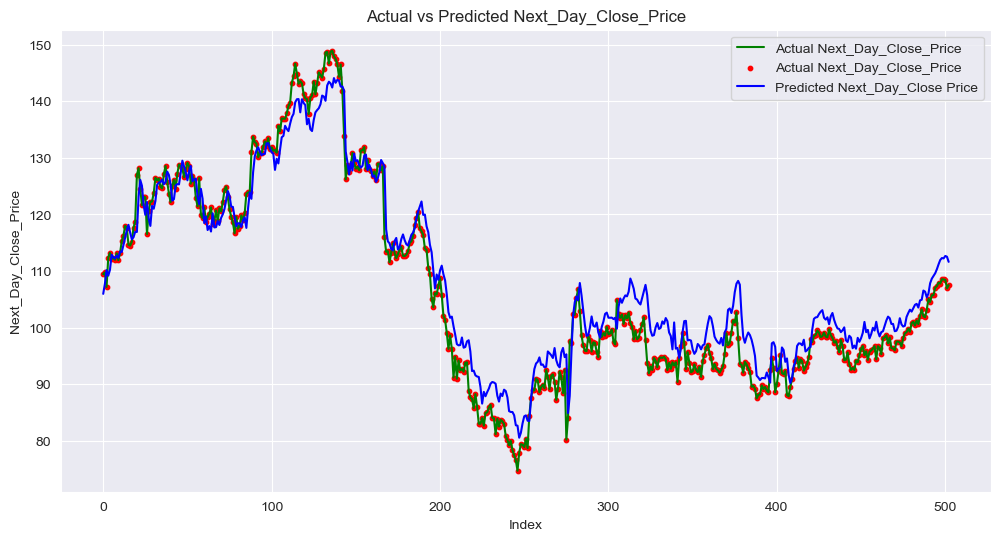

In [114]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Calculate the R2 score
r2 = r2_score(y_test, y_pred)

# Print the R2 score
print("R2 score:", r2)
# 0.84 - batch 180
# 0.74 - batch 240
# 0.85 - batch 210
import seaborn as sns

# Plotting the results
sns.set_style('darkgrid')
plt.figure(figsize=(12,6))
plt.plot(y_test.reset_index(drop=True), label='Actual Next_Day_Close_Price', color='green')
plt.scatter(y_test.reset_index(drop=True).index, y_test.reset_index(drop=True), label='Actual Next_Day_Close_Price', color='red', s=10)
plt.plot(y_pred, label='Predicted Next_Day_Close Price', color='blue')
plt.xlabel('Index')
plt.ylabel('Next_Day_Close_Price')
plt.legend()
plt.title('Actual vs Predicted Next_Day_Close_Price')
plt.show()

In [7]:
# Get the best model from the ModelCheckpoint callback
best_model_hybrid = tf.keras.models.load_model('best_model_checkpoint_cnn_transformer')
val_predict = best_model_hybrid.predict(val_images)
predicted_class = np.argmax(val_predict, axis=1)
ground_truth_class = np.argmax(val_labels, axis=1)
# Calculate metrics

from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix

accuracy = accuracy_score(ground_truth_class, predicted_class)
precision = precision_score(ground_truth_class, predicted_class, average='weighted')
f1 = f1_score(ground_truth_class, predicted_class , average='weighted')
print(f'Hybrid model')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-03-30 14:46:37.360087: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-30 14:46:37.360615: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


NameError: name 'val_images' is not defined

In [ ]:
# Get the best model from the ModelCheckpoint callback
best_model_hybrid = tf.keras.models.load_model('best_model_checkpoint_cnn_transformer')
test_predict = best_model_hybrid.predict(test_images)
predicted_class = np.argmax(test_predict, axis=1)
ground_truth_class = np.argmax(test_labels, axis=1)
# Calculate metrics

from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix

accuracy = accuracy_score(ground_truth_class, predicted_class)
precision = precision_score(ground_truth_class, predicted_class, average='weighted')
f1 = f1_score(ground_truth_class, predicted_class , average='weighted')
print(f'Hybrid model')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")


In [8]:
best_model_hybrid.build(input_shape=(None, 2, 7,1))
best_model_hybrid.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 2, 8, 1)]    0           []                               
                                                                                                  
 time_distributed_61 (TimeDistr  (None, 2, 7, 128)   384         ['input_21[0][0]']               
 ibuted)                                                                                          
                                                                                                  
 time_distributed_62 (TimeDistr  (None, 2, 3, 128)   0           ['time_distributed_61[0][0]']    
 ibuted)                                                                                          
                                                                                           

In [9]:
tuner_hybrid.results_summary(1)

NameError: name 'tuner_hybrid' is not defined

In [325]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=4, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(AveragePooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(128, return_sequences=True ,activation='relu'))
model_cnn_lstm.add(Dropout(0.2))
model_cnn_lstm.add(LSTM(216, return_sequences=False ,activation='relu'))
model_cnn_lstm.add(Dropout(0.2))
model_cnn_lstm.add(Dense(128, activation='relu'))

model_cnn_lstm.add(Dense(1, activation='relu'))
# Define the optimizer
sgd = SGD(learning_rate=0.01, momentum=0.9)
model_cnn_lstm.compile(loss='mse', optimizer='Nadam')

# Fit the model to the training data
history = model_cnn_lstm.fit(X_train_series_sub, y_train, validation_data=(X_test_series_sub, y_test), epochs=150, batch_size=140, verbose=1, callbacks=[tensorboard])

'''
# Evaluate the model on the testing data
score = model_cnn_lstm.evaluate(X_train_series_sub, y_test, verbose=0)

# Print the evaluation score
print("Test score:", score)
'''

%tensorboard --logdir={log_folder}
# Make predictions on the testing data
y_pred = model_cnn_lstm.predict(X_test_series_sub)


(503, 14)
(2012, 14)
Train set shape (2012, 2, 7, 1)
Validation set shape (503, 2, 7, 1)
Epoch 1/150


2023-03-20 17:36:59.403382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/15 [=>............................] - ETA: 1:24 - loss: 3132.1531

2023-03-20 17:37:03.061480: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-20 17:37:03.061500: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.


 2/15 [===>..........................] - ETA: 38s - loss: 3134.8928 

2023-03-20 17:37:05.971007: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-03-20 17:37:05.982701: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-03-20 17:37:05.991504: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/model_0/20230320-173656/plugins/profile/2023_03_20_17_37_05

2023-03-20 17:37:05.996393: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/model_0/20230320-173656/plugins/profile/2023_03_20_17_37_05/tangyaodeMac-mini.local.trace.json.gz
2023-03-20 17:37:06.009619: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/model_0/20230320-173656/plugins/profile/2023_03_20_17_37_05

2023-03-20 17:37:06.010710: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/model_0/20230320-173656/plugins/pr

15/15 [==============================] - ETA: 0s - loss: 2865.3384

2023-03-20 17:37:10.840667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 15s 632ms/step - loss: 2865.3384 - val_loss: 10405.9355
Epoch 2/150
Epoch 2/150
15/15 [==============================] - 2s 113ms/step - loss: 951.3391 - val_loss: 270.8309
Epoch 3/150
15/15 [==============================] - 1s 101ms/step - loss: 308.6096 - val_loss: 156.2017
Epoch 4/150
15/15 [==============================] - 2s 101ms/step - loss: 156.8587 - val_loss: 942.8873
Epoch 5/150
15/15 [==============================] - 2s 100ms/step - loss: 86.7063 - val_loss: 893.2933
Epoch 6/150
15/15 [==============================] - 1s 88ms/step - loss: 93.7783 - val_loss: 494.1534
Epoch 7/150
15/15 [==============================] - 1s 82ms/step - loss: 84.0158 - val_loss: 1639.6755
Epoch 8/150
15/15 [==============================] - 1s 69ms/step - loss: 77.6999 - val_loss: 1379.1914
Epoch 9/150
15/15 [==============================] - 1s 71ms/step - loss: 56.0682 - val_loss: 1968.9170
Epoch 10/150
15/15 [==============================] - 1s 

2023-03-20 17:39:29.304573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 2s 61ms/step


In [326]:
y_pred = best_model_hybrid.predict(X_test_series_sub)
y_pred.shape

16/16 [==============================] - 0s 17ms/step


(503, 1)

In [327]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Calculate the R2 score
r2 = r2_score(y_test, y_pred)

# Print the R2 score
print("R2 score:", r2)
# 0.84 - batch 180
# 0.74 - batch 240
# 0.85 - batch 210

R2 score: 0.9534202232926502


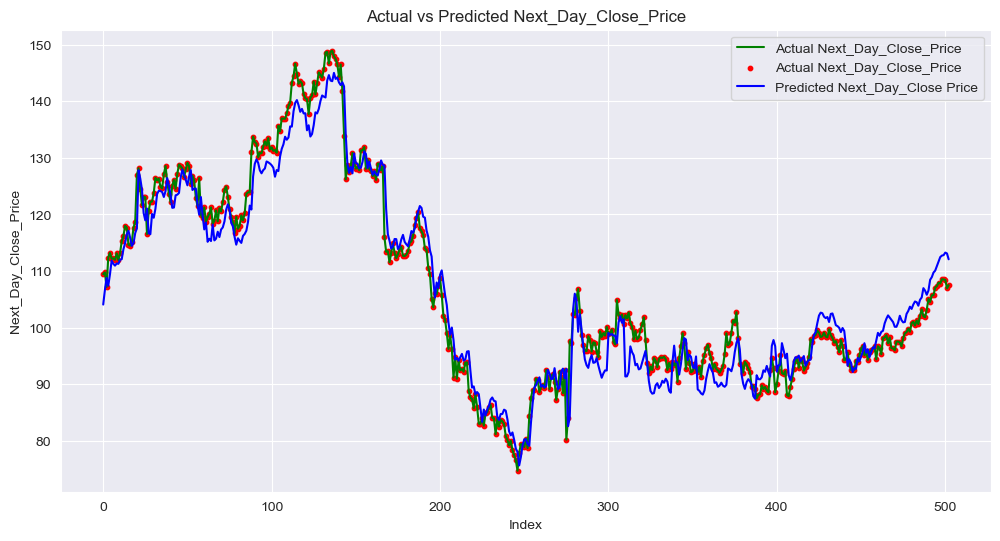

In [328]:
import seaborn as sns

# Plotting the results
sns.set_style('darkgrid')
plt.figure(figsize=(12,6))
plt.plot(y_test.reset_index(drop=True), label='Actual Next_Day_Close_Price', color='green')
plt.scatter(y_test.reset_index(drop=True).index, y_test.reset_index(drop=True), label='Actual Next_Day_Close_Price', color='red', s=10)
plt.plot(y_pred, label='Predicted Next_Day_Close Price', color='blue')
plt.xlabel('Index')
plt.ylabel('Next_Day_Close_Price')
plt.legend()
plt.title('Actual vs Predicted Next_Day_Close_Price')
plt.show()

Test score: 0.8038061071724658
R2 score: 0.8038061071724658


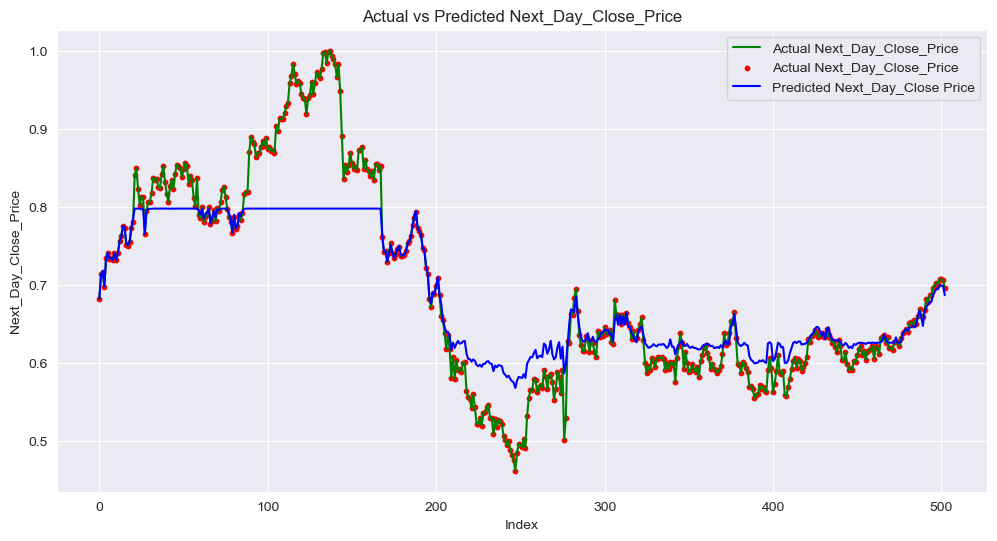

In [329]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


# Select the columns to be used as input features
features = ['Volume', 'Nasdaq_100', 'SP_500', 'Ten_Year_Treasury_Rate', 'DaysBeforeToday', 'ROA', 'GDP', 'Open_Price', 'score', 'Days_After_Last_News', 'High_Price', 'Low_Price', 'Close_Price', 'Open_Price',  'PE_Ratio', 'PE_GIVEN_TAG']

# Scale the input features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features].values)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df['Close_Price'], test_size=0.2, shuffle=False)

# Train the random forest model
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

# Evaluate the model on the testing data
score = rf.score(X_test, y_test)

# Print the evaluation score
print("Test score:", score)

# Make predictions on the testing data
y_pred = rf.predict(X_test)


# Calculate the R2 score
r2 = r2_score(y_test, y_pred)

# Print the R2 score
print("R2 score:", r2)
sns.set_style('darkgrid')
plt.figure(figsize=(12,6))
plt.plot(y_test.reset_index(drop=True), label='Actual Next_Day_Close_Price', color='green')
plt.scatter(y_test.reset_index(drop=True).index, y_test.reset_index(drop=True), label='Actual Next_Day_Close_Price', color='red', s=10)
plt.plot(y_pred, label='Predicted Next_Day_Close Price', color='blue')
plt.xlabel('Index')
plt.ylabel('Next_Day_Close_Price')
plt.legend()
plt.title('Actual vs Predicted Next_Day_Close_Price')
plt.show()

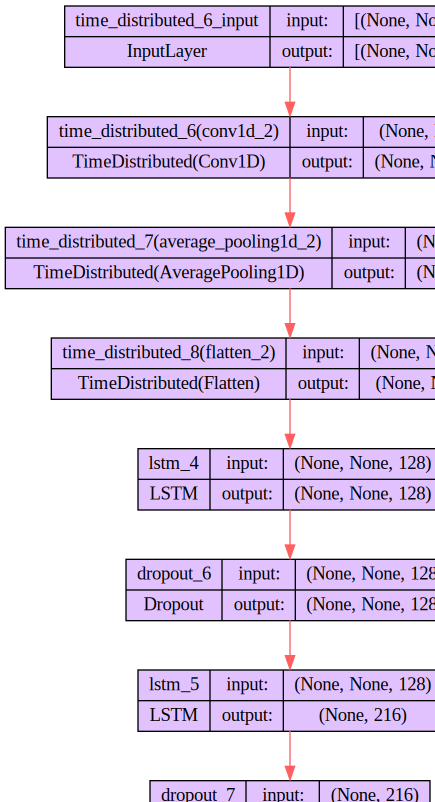

In [68]:
from tensorflow.keras.utils import plot_model
import pydot
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG, display
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=4, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(AveragePooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(128, return_sequences=True ,activation='relu'))
model_cnn_lstm.add(Dropout(0.2))
model_cnn_lstm.add(LSTM(216, return_sequences=False ,activation='relu'))
model_cnn_lstm.add(Dropout(0.2))
model_cnn_lstm.add(Dense(128, activation='relu'))

model_cnn_lstm.add(Dense(1, activation='relu'))
# Define the optimizer
sgd = SGD(learning_rate=0.01, momentum=0.9)
model_cnn_lstm.compile(loss='mse', optimizer='Nadam')

dot = model_to_dot(model_cnn_lstm, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

# Customize the nodes and edges colors
for node in dot.get_nodes():
    node.set_fillcolor('#E1C2FF')
    node.set_style('filled')
    node.set_fontcolor('#000000')

for edge in dot.get_edges():
    edge.set_color('#FF5F5F')

# Save the graph to a file
dot.write_png('models/model_structure_fancy_01.png')

# Display the graph in Jupyter Notebook (optional)
display(SVG(dot.create_svg()))

In [69]:
print("Shape of X_test_series_sub:", X_test_series_sub.shape)
print("Shape of shap_values[0]:", np.array(shap_values[0]).shape)


Shape of X_test_series_sub: (503, 2, 8, 1)
Shape of shap_values[0]: (503, 2, 8, 1)


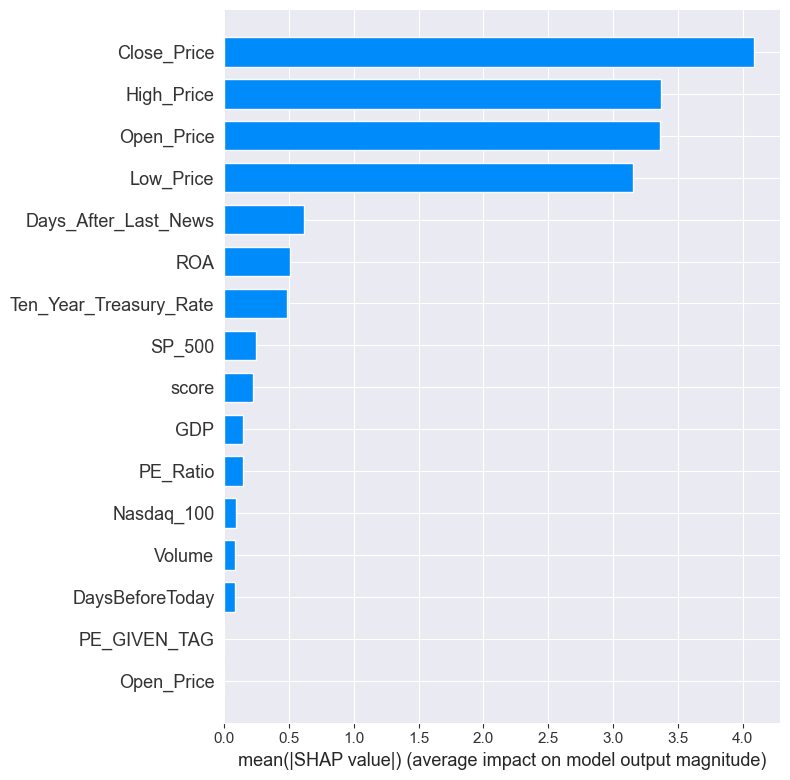

In [70]:
# Reshape the input data
X_test_series_sub_flat = np.reshape(X_test_series_sub, (503, -1))
shap_values_flat = np.reshape(shap_values[0], (503, -1))

# Plot the SHAP values
shap.summary_plot(shap_values_flat, X_test_series_sub_flat, plot_type="bar", feature_names=features)

In [71]:
import shap
import numpy as np

# Calculate the expected value
expected_value = np.mean(model.predict(X_train_series_sub))

# Flatten the input and SHAP values arrays
X_test_series_sub_flat = np.reshape(X_test_series_sub, (X_test_series_sub.shape[0], -1))
shap_values_flat = np.reshape(shap_values[0], (shap_values[0].shape[0], -1))

# Initialize the JavaScript visualizations
shap.initjs()

# Choose the index of the instance you want to visualize (you can change this to any valid index)
instance_index = 0

# Display the force plot for the chosen instance
shap.force_plot(
    expected_value,
    shap_values_flat,
    X_test_series_sub_flat,
    feature_names=features  # Replace 'features' with your array of feature names
)


63/63 [==============================] - 1s 12ms/step


63/63 [==============================] - 1s 9ms/step


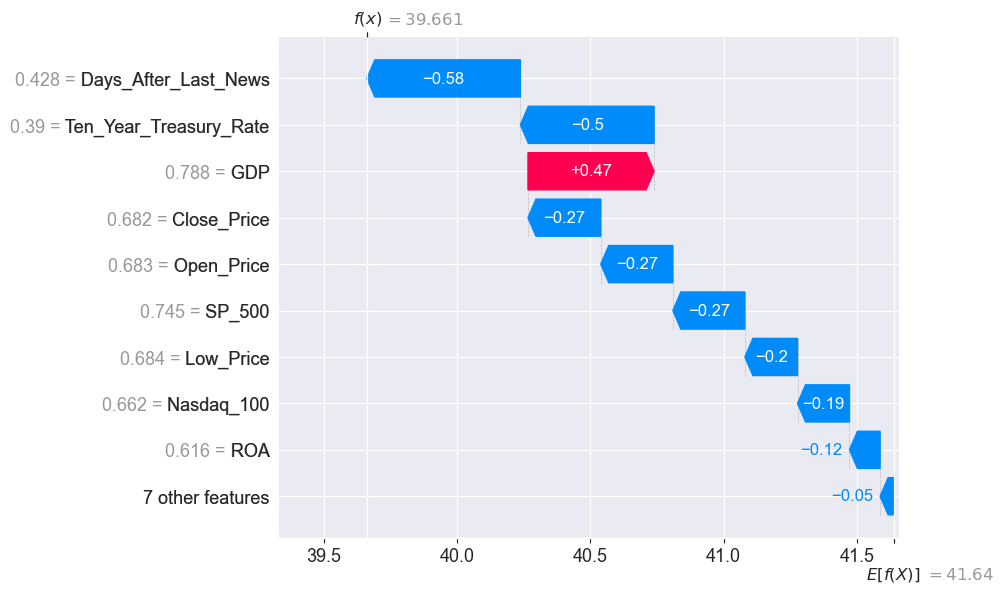

In [72]:
import shap
import numpy as np

# Calculate the expected value
expected_value = np.mean(model.predict(X_train_series_sub))

# Create a SHAP Explanation object
shap_values_explanation = shap.Explanation(
    values=shap_values_flat,
    base_values=expected_value,
    data=X_test_series_sub_flat,
    feature_names=features  # Replace 'features' with your array of feature names
)

# Initialize the JavaScript visualizations
shap.initjs()

# Choose the index of the instance you want to visualize (you can change this to any valid index)
instance_index = 0

# Display the waterfall plot for the chosen instance
shap.plots.waterfall(
    shap_values_explanation[instance_index]
)



In [60]:
import shap

# Create a GradientExplainer object
explainer = shap.GradientExplainer(model, X_test_series_sub)


shap_values = explainer.shap_values(X_test_series_sub)

# Plot the SHAP values
shap.summary_plot(shap_values[0], X_test_series_sub, plot_type="bar")

TypeError: 'NoneType' object cannot be interpreted as an integer

In [116]:
model = tf.keras.models.load_model('models/CNN_TRANSFORMER.h5')

In [73]:
import shap
import numpy as np

# Calculate the expected value
expected_value = np.mean(model.predict(X_train_series_sub))

# Flatten the input and SHAP values arrays
X_test_series_sub_flat = np.reshape(X_test_series_sub, (X_test_series_sub.shape[0], -1))
shap_values_flat = np.reshape(shap_values[0], (shap_values[0].shape[0], -1))

# Choose the index of the instance you want to visualize (you can change this to any valid index)
instance_index = 0

# Create the force plot
force_plot = shap.force_plot(
    expected_value,
    shap_values_flat,
    X_test_series_sub_flat,
    feature_names=features,  # Replace 'features' with your array of feature names
    show=False
)

# Save the force plot to an HTML file
with open('force_plot.html', 'w') as f:
    f.write(shap.getjs() + force_plot.html())

63/63 [==============================] - 1s 9ms/step


In [117]:
print_feature_importances_shap_values(shap_values_explanation, features)

Close_Price -> 4.0841 (softmax = 0.3808)
High_Price -> 3.3681 (softmax = 0.1861)
Open_Price -> 3.3614 (softmax = 0.1849)
Low_Price -> 3.1559 (softmax = 0.1505)
Days_After_Last_News -> 0.6165 (softmax = 0.0119)
ROA -> 0.5085 (softmax = 0.0107)
Ten_Year_Treasury_Rate -> 0.4828 (softmax = 0.0104)
SP_500 -> 0.2432 (softmax = 0.0082)
score -> 0.2200 (softmax = 0.0080)
GDP -> 0.1433 (softmax = 0.0074)
PE_Ratio -> 0.1418 (softmax = 0.0074)
Nasdaq_100 -> 0.0887 (softmax = 0.0070)
Volume -> 0.0835 (softmax = 0.0070)
DaysBeforeToday -> 0.0806 (softmax = 0.0070)
PE_GIVEN_TAG -> 0.0000 (softmax = 0.0064)


In [42]:
from scipy.special import softmax

def print_feature_importances_shap_values(shap_values, features):
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''
    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
    # Calculates the normalized version
    importances_norm = softmax(importances)
    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")

In [47]:
!pip install netron

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.1 MB/s eta 0:00:00a 0:00:01


In [118]:
import netron

# Start the Netron server to visualize the model
netron.start('models/CNN_TRANSFORMER.h5')

Serving 'models/CNN_TRANSFORMER.h5' at http://localhost:16501


('localhost', 16501)

In [53]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=4, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(AveragePooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(128, return_sequences=True ,activation='relu'))
model_cnn_lstm.add(Dropout(0.2))
model_cnn_lstm.add(LSTM(216, return_sequences=False ,activation='relu'))
model_cnn_lstm.add(Dropout(0.2))
model_cnn_lstm.add(Dense(128, activation='relu'))

model_cnn_lstm.add(Dense(1, activation='relu'))
# Define the optimizer
sgd = SGD(learning_rate=0.01, momentum=0.9)
model_cnn_lstm.compile(loss='mse', optimizer='Nadam',metrics=["mean_absolute_error"])
stop_early_1 = tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error', mode='min', patience=10)
# Fit the model to the training data
history = model_cnn_lstm.fit(X_train_series_sub, y_train, validation_data=(X_test_series_sub, y_test), epochs=150, batch_size=140, verbose=1, callbacks=[stop_early_1])

'''
# Evaluate the model on the testing data
score = model_cnn_lstm.evaluate(X_train_series_sub, y_test, verbose=0)

# Print the evaluation score
print("Test score:", score)
'''
# Make predictions on the testing data
y_pred = model_cnn_lstm.predict(X_test_series_sub)

Epoch 1/150


2023-03-30 15:30:58.427088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 2869.3186 - mean_absolute_error: 43.3613

2023-03-30 15:31:01.008592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 4s 119ms/step - loss: 2869.3186 - mean_absolute_error: 43.3613 - val_loss: 10511.9785 - val_mean_absolute_error: 101.0940
Epoch 2/150
15/15 [==============================] - 1s 59ms/step - loss: 962.6780 - mean_absolute_error: 23.9952 - val_loss: 199.1636 - val_mean_absolute_error: 11.1574
Epoch 3/150
15/15 [==============================] - 1s 56ms/step - loss: 304.7731 - mean_absolute_error: 15.5640 - val_loss: 112.8399 - val_mean_absolute_error: 9.1563
Epoch 4/150
15/15 [==============================] - 1s 56ms/step - loss: 158.1622 - mean_absolute_error: 10.8639 - val_loss: 244.1939 - val_mean_absolute_error: 13.1298
Epoch 5/150
15/15 [==============================] - 1s 54ms/step - loss: 106.4809 - mean_absolute_error: 8.3650 - val_loss: 1457.2262 - val_mean_absolute_error: 35.7986
Epoch 6/150
15/15 [==============================] - 1s 54ms/step - loss: 76.6668 - mean_absolute_error: 6.7280 - val_loss: 828.4163 - val_mean_absolute_error

2023-03-30 15:32:43.135106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 1s 18ms/step


R2 score: 0.9704002646549166


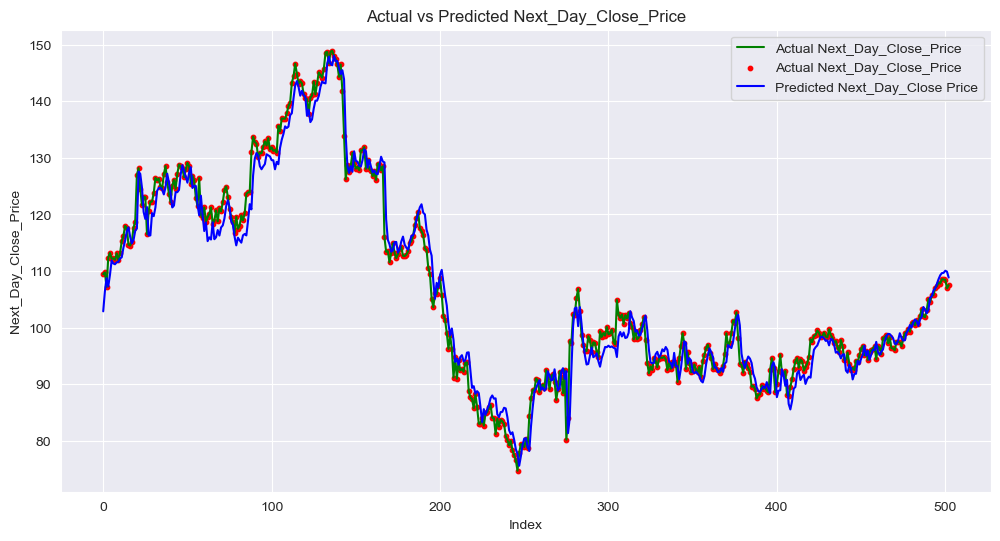

In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
# Calculate the R2 score
r2 = r2_score(y_test, y_pred)

# Print the R2 score
print("R2 score:", r2)
sns.set_style('darkgrid')
plt.figure(figsize=(12,6))
plt.plot(y_test.reset_index(drop=True), label='Actual Next_Day_Close_Price', color='green')
plt.scatter(y_test.reset_index(drop=True).index, y_test.reset_index(drop=True), label='Actual Next_Day_Close_Price', color='red', s=10)
plt.plot(y_pred, label='Predicted Next_Day_Close Price', color='blue')
plt.xlabel('Index')
plt.ylabel('Next_Day_Close_Price')
plt.legend()
plt.title('Actual vs Predicted Next_Day_Close_Price')
plt.show()

In [56]:
model_cnn_lstm.save('models/CNN_LSTM.h5')


In [82]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=4, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=4)))

model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(128, return_sequences=True ,activation='relu'))
model_cnn_lstm.add(Dropout(0.2))
model_cnn_lstm.add(LSTM(256, return_sequences=False ,activation='relu'))
model_cnn_lstm.add(Dropout(0.2))
model_cnn_lstm.add(Dense(128, activation='relu'))

model_cnn_lstm.add(Dense(1, activation='relu'))
# Define the optimizer

model_cnn_lstm.compile(loss='mse', optimizer='Nadam', metrics=['mean_absolute_error'])
stop_early_1 = tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error', mode='min', patience=10)
# Fit the model to the training data
history = model_cnn_lstm.fit(X_train_series_sub, y_train, validation_data=(X_test_series_sub, y_test), epochs=150, batch_size=140, verbose=1, callbacks=[stop_early_1])

Epoch 1/150


2023-03-30 15:51:54.620956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 2865.5859 - mean_absolute_error: 43.2710

2023-03-30 15:51:57.987191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 5s 162ms/step - loss: 2865.5859 - mean_absolute_error: 43.2710 - val_loss: 10412.6348 - val_mean_absolute_error: 100.5280
Epoch 2/150
15/15 [==============================] - 1s 68ms/step - loss: 1356.1654 - mean_absolute_error: 29.6160 - val_loss: 2299.6868 - val_mean_absolute_error: 44.6328
Epoch 3/150
15/15 [==============================] - 1s 61ms/step - loss: 800.3578 - mean_absolute_error: 24.9404 - val_loss: 493.3763 - val_mean_absolute_error: 17.2064
Epoch 4/150
15/15 [==============================] - 1s 66ms/step - loss: 638.0187 - mean_absolute_error: 22.4154 - val_loss: 278.9666 - val_mean_absolute_error: 14.4810
Epoch 5/150
15/15 [==============================] - 1s 63ms/step - loss: 481.5063 - mean_absolute_error: 19.3172 - val_loss: 468.0392 - val_mean_absolute_error: 17.9990
Epoch 6/150
15/15 [==============================] - 1s 63ms/step - loss: 316.9220 - mean_absolute_error: 15.6420 - val_loss: 258.0506 - val_mean_absolute_

In [83]:
model_cnn_lstm.save('models/CNN_LSTM_PE.h5')

In [84]:
y_pred = model_cnn_lstm.predict(X_test_series_sub)

2023-03-30 15:53:16.839948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 1s 29ms/step


R2 score: 0.9536901496588517


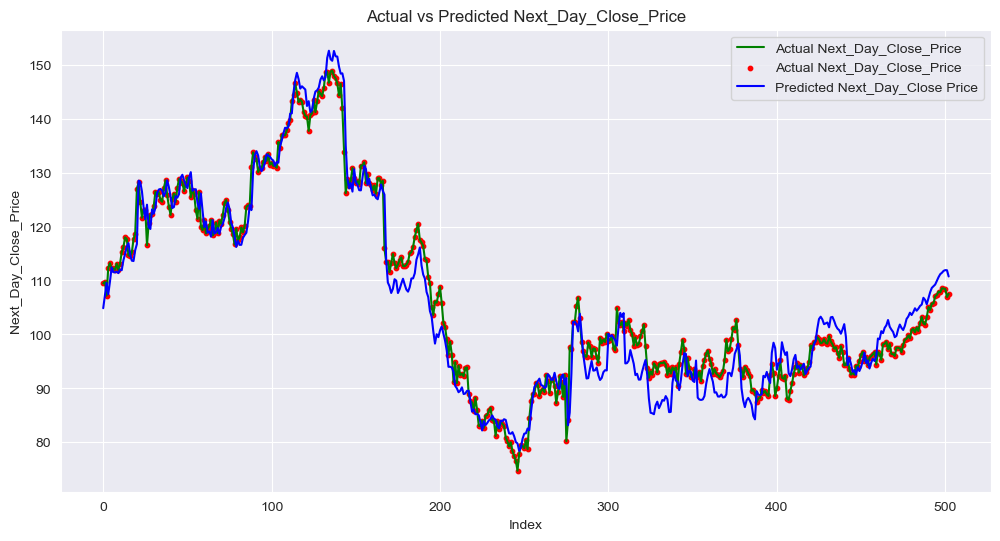

In [85]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
# Calculate the R2 score
r2 = r2_score(y_test, y_pred)

# Print the R2 score
print("R2 score:", r2)
sns.set_style('darkgrid')
plt.figure(figsize=(12,6))
plt.plot(y_test.reset_index(drop=True), label='Actual Next_Day_Close_Price', color='green')
plt.scatter(y_test.reset_index(drop=True).index, y_test.reset_index(drop=True), label='Actual Next_Day_Close_Price', color='red', s=10)
plt.plot(y_pred, label='Predicted Next_Day_Close Price', color='blue')
plt.xlabel('Index')
plt.ylabel('Next_Day_Close_Price')
plt.legend()
plt.title('Actual vs Predicted Next_Day_Close_Price')
plt.show()